In [325]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm as cm_mlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import scipy
%matplotlib inline
plt.viridis()
from matplotlib import animation, rc, colors
from IPython.display import HTML
from brian2.units import *
import matplotlib as mlib
from scipy import stats
from pprint import pprint as pp
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from simulation_statistics.analysis_functions_definitions import *
import traceback
from sklearn.metrics import confusion_matrix, classification_report

In [326]:
mlib.rcParams.update({'font.size': 24})
mlib.rcParams.update({'errorbar.capsize': 5})
mlib.rcParams.update({'figure.autolayout': True})

In [327]:
# https://gist.github.com/MatthewJA/5a0a6d75748bf5cb5962cb9d5572a6ce
cyclic_viridis = colors.LinearSegmentedColormap.from_list(
    'cyclic_viridis',
    [(0, cm_mlib.viridis.colors[0]),
     (0.25, cm_mlib.viridis.colors[256 // 3]),
     (0.5, cm_mlib.viridis.colors[2 * 256 // 3]),
     (0.75, cm_mlib.viridis.colors[-1]),
     (1.0, cm_mlib.viridis.colors[0])])

In [328]:
# Random delay initial network
fname = "random_delay_smax_128_gmax_1_384k_sigma_7.5_3_angle_0_90_evo"



# Constant delay initial network

# Complete the file name with training or testing
training_type = "min_"
# training_type = "max_"
training_type = "uns_"

training_fname = "training_readout_for_" + training_type + fname 
testing_fname = "testing_readout_for_" + training_type + fname

# root_stats = "D:\Work\Neurogenesis-PhD\simulation_statistics\\"
root_stats = "C:\Work\phd\simulation_statistics\\"

# root_syn = "D:\Work\Neurogenesis-PhD\synaptogenesis\\"
root_syn = "C:\Work\phd\synaptogenesis\\"

suffix_test = ""
# suffix_test = "_shared_seed"
# suffix_test = "_1_angle_jitter"
suffix_test = "_2_angles"
# suffix_test = "_4_angles"
# suffix_test = "_all_angles"
# suffix_test = "_45_degrees"
# suffix_test = "_64x64"

suffix_test += training_type
training_data = np.load(root_syn + training_fname + ".npz")
testing_data = np.load(root_syn + testing_fname + ".npz")
# testing_data = np.load(root_syn + "spiking_moving_bar_input\spiking_moving_bar_motif_bank_simtime_1200s.npz")

In [329]:
# Retreive data from testing data
testing_target_spikes = testing_data['target_spikes']
testing_inhibitory_spikes = testing_data['inhibitory_spikes']
testing_readout_spikes = testing_data['readout_spikes']
testing_actual_classes = testing_data['actual_classes']

readout_sim_params = testing_data['readout_sim_params'].ravel()[0]
pp(readout_sim_params)
w_max = readout_sim_params['argparser']['w_max']
simtime = testing_data['simtime'] * ms

# Retreive data from training data
training_actual_classes = training_data['actual_classes']
target_readout_projection = training_data['target_readout_projection']
wta_projection = training_data['wta_projection']



target_readout_projection = target_readout_projection.reshape(target_readout_projection.size/4, 4)
wta_projection = wta_projection.reshape(wta_projection.size/4, 4)
classes = np.sort(np.unique(testing_actual_classes))

training_data.close()
testing_data.close()

{'a_minus': 0.11999999999999998,
 'a_plus': 0.1,
 'actual_classes': array([[90, 90,  0,  0, 90,  0, 90,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        90, 90, 90,  0, 90,  0, 90, 90, 90, 90,  0,  0, 90,  0, 90, 90,  0,
         0,  0,  0, 90,  0, 90, 90, 90,  0,  0,  0,  0, 90,  0, 90, 90, 90,
         0,  0,  0, 90,  0,  0, 90, 90,  0, 90, 90,  0,  0,  0,  0,  0,  0,
        90,  0, 90,  0,  0, 90, 90,  0,  0,  0,  0,  0, 90, 90, 90,  0,  0,
        90,  0, 90,  0,  0,  0,  0,  0, 90,  0, 90, 90,  0,  0,  0,  0, 90,
        90, 90,  0, 90, 90, 90, 90,  0, 90, 90,  0, 90, 90,  0,  0,  0, 90,
        90,  0, 90, 90, 90,  0, 90, 90, 90, 90,  0,  0, 90, 90, 90, 90,  0,
         0,  0, 90, 90,  0, 90,  0, 90,  0, 90,  0,  0,  0, 90,  0, 90,  0,
         0, 90, 90,  0,  0, 90, 90,  0, 90, 90,  0,  0, 90, 90, 90,  0, 90,
         0, 90,  0, 90, 90,  0, 90,  0, 90, 90, 90,  0, 90,  0,  0, 90,  0,
        90, 90, 90, 90,  0, 90, 90,  0, 90, 90, 90, 90,  0]], dtype=int64),
 'argparser': {'a_pl

# Readout spikes

In [330]:
def plot_spikes(spikes, title, classes, filename):
    if spikes is not None:
        recast_spikes = []
        for index, value in np.ndenumerate(classes):
            recast_spikes.append(spikes[spikes[:,0]==index[0]][:,1])
        f, ax1 = plt.subplots(1, 1, figsize=(15, 6), dpi=600)
        ax1.set_xlim((0, simtime/ms))
#         print recast_spikes
        ax1.eventplot(recast_spikes, linelengths=.8)
        ax1.set_xlabel('Time/ms')
        ax1.set_ylabel('Class neuron')
        ax1.set_title(title)
        plt.savefig(filename, bbox_inches='tight')
        ax1.set_yticks(np.arange(classes.size))
        ax1.set_yticklabels(np.sort(classes))
        plt.show()

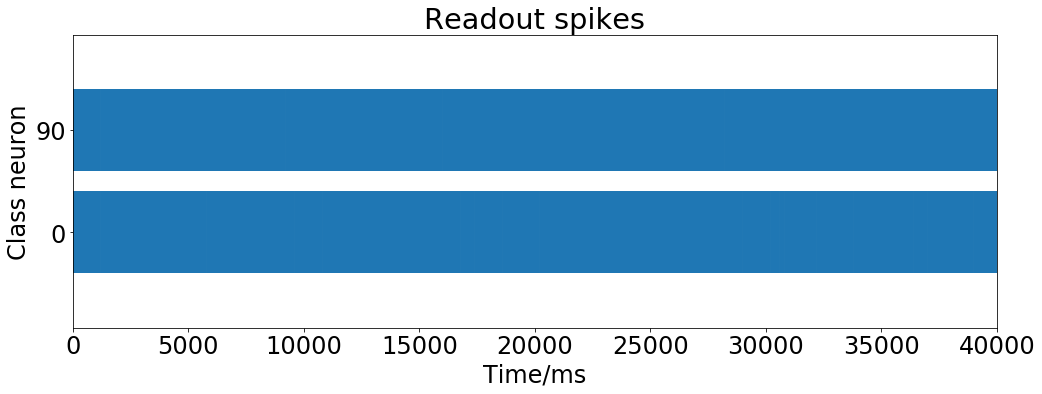

In [331]:
plot_spikes(testing_readout_spikes, "Readout spikes", np.unique(testing_actual_classes), "readout_spikes{}.pdf".format(suffix_test))

In [332]:
spikes = testing_readout_spikes
for index, value in np.ndenumerate(classes):
    print "Number of spikes for class", value, ":", spikes[spikes[:,0]==index[0]].size, "equivalent of ", spikes[spikes[:,0]==index[0]].size / simtime


Number of spikes for class 0 : 12880 equivalent of  0.322 kHz
Number of spikes for class 90 : 14854 equivalent of  0.37135 kHz


In [333]:
testing_actual_classes

array([[90, 90,  0,  0, 90,  0, 90,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        90, 90, 90,  0, 90,  0, 90, 90, 90, 90,  0,  0, 90,  0, 90, 90,  0,
         0,  0,  0, 90,  0, 90, 90, 90,  0,  0,  0,  0, 90,  0, 90, 90, 90,
         0,  0,  0, 90,  0,  0, 90, 90,  0, 90, 90,  0,  0,  0,  0,  0,  0,
        90,  0, 90,  0,  0, 90, 90,  0,  0,  0,  0,  0, 90, 90, 90,  0,  0,
        90,  0, 90,  0,  0,  0,  0,  0, 90,  0, 90, 90,  0,  0,  0,  0, 90,
        90, 90,  0, 90, 90, 90, 90,  0, 90, 90,  0, 90, 90,  0,  0,  0, 90,
        90,  0, 90, 90, 90,  0, 90, 90, 90, 90,  0,  0, 90, 90, 90, 90,  0,
         0,  0, 90, 90,  0, 90,  0, 90,  0, 90,  0,  0,  0, 90,  0, 90,  0,
         0, 90, 90,  0,  0, 90, 90,  0, 90, 90,  0,  0, 90, 90, 90,  0, 90,
         0, 90,  0, 90, 90,  0, 90,  0, 90, 90, 90,  0, 90,  0,  0, 90,  0,
        90, 90, 90, 90,  0, 90, 90,  0, 90, 90, 90, 90,  0]], dtype=int64)

In [334]:
training_actual_classes

array([[ 0,  0, 90, 90, 90,  0, 90,  0,  0,  0, 90, 90,  0, 90,  0, 90,  0,
        90, 90, 90, 90, 90, 90,  0,  0,  0, 90,  0, 90,  0, 90, 90, 90, 90,
         0, 90, 90, 90, 90,  0,  0,  0,  0,  0,  0, 90,  0, 90, 90,  0, 90,
        90, 90,  0,  0, 90,  0, 90, 90,  0,  0, 90,  0, 90,  0, 90,  0,  0,
        90, 90, 90,  0,  0,  0,  0,  0, 90,  0, 90, 90,  0, 90, 90,  0, 90,
        90, 90,  0, 90, 90, 90, 90, 90, 90,  0, 90,  0, 90,  0,  0,  0, 90,
         0, 90,  0, 90, 90,  0, 90, 90, 90,  0, 90,  0, 90,  0, 90, 90,  0,
         0,  0, 90,  0,  0,  0, 90, 90,  0,  0,  0, 90, 90,  0,  0,  0, 90,
         0,  0, 90, 90,  0, 90,  0,  0, 90, 90,  0,  0,  0, 90,  0, 90, 90,
         0, 90, 90,  0, 90,  0,  0,  0, 90,  0, 90, 90,  0, 90,  0, 90, 90,
        90,  0, 90,  0,  0,  0,  0,  0, 90, 90, 90,  0, 90,  0, 90,  0,  0,
         0,  0, 90,  0,  0,  0,  0, 90, 90, 90,  0, 90,  0]], dtype=int64)

# Do readout spikes have any classification power?

In [335]:
chunk = 200
instaneous_rates = np.empty((classes.size, int((simtime/ms)//chunk)))
for index, value in np.ndenumerate(instaneous_rates):
    number_index, chunk_index = index
    instaneous_rates[number_index, chunk_index] = np.count_nonzero(
            np.logical_and(
                testing_readout_spikes[testing_readout_spikes[:,0]==number_index][:, 1] >= (chunk_index * chunk), 
                testing_readout_spikes[testing_readout_spikes[:,0]==number_index][:, 1] < ((chunk_index+1) * chunk)
            )
        ) 

In [336]:
what_network_thinks = np.empty(int((simtime/ms)//chunk))
for i in range(what_network_thinks.shape[0]):
    what_network_thinks[i] = np.argmax(instaneous_rates[:, i])

In [337]:
print classification_report(testing_actual_classes.ravel(), classes[what_network_thinks.astype(int)].ravel())

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       100
         90       0.49      0.96      0.65       100

avg / total       0.24      0.48      0.32       200



In [338]:
classes[what_network_thinks.astype(int)]

array([90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90,  0, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,  0, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,
       90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90,  0, 90,
       90,  0, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90, 90], dtype=int64)

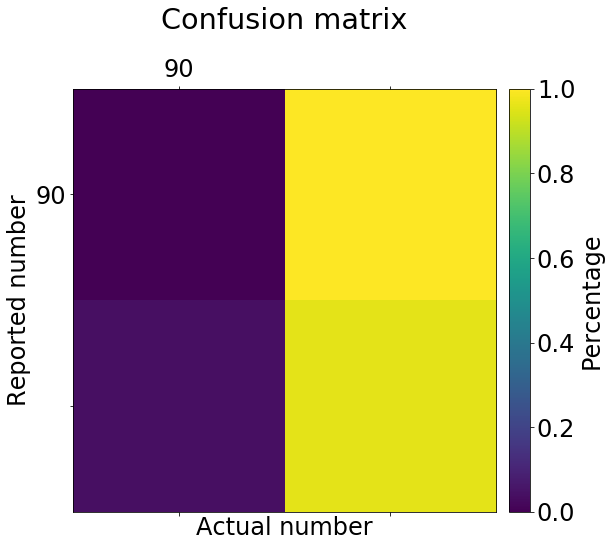

In [347]:
confusion = confusion_matrix(testing_actual_classes.ravel(), classes[what_network_thinks.astype(int)].ravel(),  labels=classes)
confusion = confusion.astype('float') / confusion.sum(axis=1)

fig_conn, ax1 = plt.subplots(1, 1,figsize=(9,9), dpi=800)
    

ff_conn_ax = ax1.matshow(confusion, vmin=0, vmax=1)

ax1.set_title("Confusion matrix\n")
ax1.set_xlabel("Actual number")
ax1.set_ylabel("Reported number")

ax1.set_xticklabels(classes)
ax1.set_yticklabels(classes)


divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(ff_conn_ax, cax=cax)
cbar.set_label("Percentage")

plt.tight_layout()
plt.savefig("confusion_matrix{}.pdf".format(suffix_test), bbox_inches='tight', dpi=800)

In [348]:
classes

array([ 0, 90], dtype=int64)

# Readout weights

In [ ]:
conns = []
conns_names = []
for index, value in np.ndenumerate(classes):
    conns.append(target_readout_projection[target_readout_projection[:,1]==index[0]])
    conns_names.append("$readout_{%s}$" % str(value))
f, axes = plt.subplots(1,classes.size, figsize=(15, 7), dpi=800, sharey=True)



minimus = 0
maximus = 1
for index, ax in np.ndenumerate(axes): 
    i = index[0]
#     ax.axvline((i*90/180.)*np.pi, color="#aaaaaa", lw=4, zorder=1)
#     c = ax.fill(radians, super_selective_tuning_curves[i, :], c=viridis_cmap(float(i)/(no_files-1)),  
#                 alpha=0.9, fill=False,lw=4, zorder=2)
#     ax.set_xlabel("${}^\circ$".format(i*90))
    ax.hist(conns[i][:,2]/w_max, bins=20, color='#414C82', edgecolor='k')
    ax.set_title(conns_names[i])
    ax.set_xlim([minimus, maximus])
#     ax.set_xticklabels(["0", "0.5", "1"])
#     print conns[i][:,2]

# f.suptitle("Mean firing rate for specific input angle", va='bottom')
plt.tight_layout()
plt.savefig("readout_weight_histograms{}.pdf".format(suffix_test), bbox_inches='tight')
plt.show()